# Fidelity Portfolio Review
### V 0.2.0

## What does it do?

This notebook imports data from a csv of account positions, copies the data into a new excel workbook, and fills in additional columns with additional information, such as P/E Ratios, Recognia Technical Analysis, etc.

## How does it work?

This notebook uses the Selenium Webdriver to automate Firefox to navigate through Fidelity's stock research pages and extract useful information. 

After extracting the data, other cells can be run to clean the data, add conditional formatting to an excel document containing the data, and (coming soon) perform visualization with the data.

## Dependencies

- Selenium V 3.141.0
- Gecko Webdriver installed in system path
- Pandas
- Numpy
- Matplotlib
- Bokeh


## Instructions for use

1. From fidelity.com, log in and navigate to your account positions. Be sure you are viewing your positions with the Beta view (as of 3/13/2021). Click on the 'Share' icon, and click download. This will download a .csv of your account positions. Place this .csv file in the same folder as this notebook.

2. In the first python code cell, replace the .csv file name with the name of your .csv file.

3. Run the first cell to import the necessary libraries and modules and open a Firefox browser window that can be controlled by the Selenium Webdriver.

4. Before running the next cell, log into Fidelity as you normally would. The stock research data we're looking for is only available if you are logged into your account. 





In [1]:
# import modules
from selenium.webdriver import Firefox
from selenium.common.exceptions import NoSuchElementException
import time
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
import re
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from datetime import datetime
import extract
import shutil
# import yfinance

def convert_to_float(value, **kwargs):
    if isinstance(value, str):
        value = re.sub('[\$,%+]', '', value)
        if value == "--":
            value = np.nan
    return np.float(value)

# import the csv file:

# at this time, I'm unsure if I want to continue using TK to open the csv file; last time I tried, it froze up my notebook.

# root = Tk()
# root.withdraw()
# source_data = askopenfilename()
# for now, just use the direct file path
stock_df = pd.read_csv('test_data.csv', index_col=False)
stock_df = stock_df.sort_values('Symbol')

# add the necessary columns to the df for the data we will be extracting
columns_list = ['Symbol', 'Description', 'Quantity', 'Last Price', 'Last Price Change', 'Current Value', "Today's Gain/Loss Dollar", "Today's Gain/Loss Percent", "Total Gain/Loss Dollar", "Total Gain/Loss Percent", "Percent Of Account", "Cost Basis", "Cost Basis Per Share", 'Div. Amt', 'Div. Yield', 'Equity Summary Score', 'Recognia Short Term', 'Recognia Intermediate Term', 'Recognia Long Term', 'Valuation', 'Quality', 'Growth Stability', 'Financial Health', '1-Yr Price Target', 'P/E TTM', 'P/E 5-Yr Avg', 'P/CF Recent Quarter', 'P/CF TTM', 'P/Sales Recent Quarter', 'P/Sales TTM', 'P/B', 'Debt/Equity TTM', 'Debt/Equity Recent Quarter', '52-Week Performance', "Account Name/Number"]
stock_df = stock_df.reindex(columns = columns_list)

current_time = datetime.now().strftime('%m%d%y_%H%M%S')
new_workbook = f'target_workbook_{current_time}.xlsx'

# make a copy of the target_workbook w/ the datetime in the name
# NOTE: not needed, since conditional formatting needs to be applied directly w/ openpyxl
# shutil.copy2('target_workbook.xlsx', new_workbook)

# next step: copy the existing data into the new excel document
# we will be periodically overwriting this notebook
# this will serve as backup for our data if the extract cell crashes
stock_df.to_excel(new_workbook)

# after that, open the web browser
driver = Firefox()
driver.get('https://www.fidelity.com/')
driver.execute_script('''window.open("https://finance.yahoo.com/quote/V?p=V&.tsrc=fin-srch", "_blank");''')
fidelity_window = driver.window_handles[0]
yf_window = driver.window_handles[1]
driver.switch_to.window(window_name=fidelity_window)


## Next,
Log into Fidelity's website as you normally would. Once you have logged on to Fidelity's website, you can run the data extraction cell below.

In [3]:
# create a list of symbols to iterate over
# symbols = [i for i in stock_df['Symbol']]

# define a prev_symbol variable to save time
prev_symbol = ""

# var set to control when to save to excel
i = 0
error_count = 0

# iterate thru the symbols and write to the DF
for row in stock_df.itertuples():
    
    if (stock_df.iloc[i, 33] > 0) | (stock_df.iloc[i, 33] < 0):
        i += 1
        continue

    symbol = row[1]

    if symbol == 'Pending Activity':
        i += 1
        continue
    elif symbol == 'SPAXX**':
        i += 1
        continue

    # check to see if we already have data for the symbol

        
    # GIANT try/except block (tbh too big)
    # if we run into a 'NoSuchElementException', we go to the fidelity homepage, then try reloading the page
    # the while loop is used in case of an error that causes the page to get reloaded; that way, it doesn't skip symbols and place data in the wrong place (hopefully)
    
    success = False

    while success is False:
    
        try:

            # load the page, and scroll thru it
            driver.execute_script("window.scrollTo(0, 0)")

            driver.get(f"https://snapshot.fidelity.com/fidresearch/snapshot/landing.jhtml#/research?symbol={symbol}&appCode=&optInNRE=")
            time.sleep(5)   # pauses may need to be adjusted based on network connection
            driver.execute_script("window.scrollTo(0, 0)")
            time.sleep(3)
            driver.execute_script("window.scrollTo(0,(document.body.scrollHeight / 2))")
            time.sleep(3)
            driver.execute_script("window.scrollTo(0,document.body.scrollHeight)")

            # now, check the security type
            sec_type = extract.determine_security_type(driver)
            if sec_type == 'Stocks':

                # Dividends
                dividends = extract.stock_div_yield(driver)
                stock_df.at[row.Index, 'Div. Amt'] = dividends[0]
                stock_df.at[row.Index, 'Div. Yield'] = dividends[1]

                # Equity Summary Score
                try:
                    equity_sum_score = extract.stock_equity_sum_score(driver)
                except:
                    equity_sum_score = np.nan
                stock_df.at[row.Index, 'Equity Summary Score'] = equity_sum_score

                # Recognia Technical Analysis
                recognia_dict = extract.recognia_analysis(driver, sec_type)
                stock_df.loc[row.Index, 'Recognia Short Term'] = recognia_dict['Recognia Short Term']
                stock_df.loc[row.Index, 'Recognia Intermediate Term'] = recognia_dict['Recognia Intermediate Term']
                stock_df.loc[row.Index, 'Recognia Long Term'] = recognia_dict['Recognia Long Term']

                # Stock Valuation
                valuation = extract.stock_valuation(driver)
                stock_df.at[row.Index, 'Valuation'] = valuation

                # Stock Quality
                quality = extract.stock_quality(driver)
                stock_df.at[row.Index, 'Quality'] = quality

                # Stock Growth Stability
                growth_stability = extract.stock_growth_stability(driver)
                stock_df.at[row.Index, 'Growth Stability'] = growth_stability

                # Stock Financial Health
                financial_health = extract.stock_financial_health(driver)
                stock_df.at[row.Index, 'Financial Health'] = financial_health

                # 52-Week Performance
                ftw_perf = extract.stock_growth_stability(driver)
                try:
                    stock_df.at[row.Index, '52-Week Performance'] = ftw_perf
                except:
                    stock_df.loc[row.Index, '52-Week Performance'] = np.nan

                time.sleep(1)

                # Key Stats
                # I'm honestly not sure if this will work
                key_stats = extract.stock_key_stats(driver, symbol)
                try: 
                    stock_df.at[row.Index, 'P/E TTM'] = key_stats[0]['P/E (Trailing Twelve Months)']
                except:
                    stock_df.loc[row.Index, 'P/E TTM'] = np.nan
                try:
                    stock_df.at[row.Index, 'P/E 5-Yr Avg'] = key_stats[0]['P/E (5-Year Average)']
                except:
                    stock_df.loc[row.Index, 'P/E 5-Yr Avg'] = np.nan
                try:
                    stock_df.at[row.Index, 'P/CF Recent Quarter'] = key_stats[0]['Price/Cash Flow (Most Recent Quarter)']
                except:
                    stock_df.loc[row.Index, 'P/CF Recent Quarter'] = np.nan
                try:
                    stock_df.at[row.Index, 'P/CF TTM'] = key_stats[0]['Price/Cash Flow (TTM)']
                except:
                    stock_df.loc[row.Index, 'P/CF TTM'] = np.nan
                try:
                    stock_df.at[row.Index, 'P/Sales Recent Quarter'] = key_stats[0]['Price/Cash Flow (TTM)']
                except:
                    stock_df.loc[row.Index, 'P/Sales Recent Quarter'] = np.nan
                try:
                    stock_df.at[row.Index, 'P/Sales TTM'] = key_stats[0]['Price/Sales (TTM)']
                except:
                    stock_df.loc[row.Index, 'P/Sales TTM'] = np.nan
                try:
                    stock_df.at[row.Index, 'P/B'] = key_stats[0]['Price/Book']
                except:
                    stock_df.loc[row.Index, 'P/B'] = np.nan
                try:
                    stock_df.at[row.Index, 'Debt/Equity TTM'] = key_stats[1]['Total Debt/Equity (Most Recent Quarter, Annualized)']
                except:
                    stock_df.loc[row.Index, 'Debt/Equity TTM'] = np.nan
                try:
                    stock_df.at[row.Index, 'Debt/Equity Recent Quarter'] = key_stats[1]['Total Debt/Equity (TTM)']
                except:
                    stock_df.loc[row.Index, 'Debt/Equity Recent Quarter'] = np.nan

                time.sleep(1)

                # 1-Yr Price Target
                try:
                    price_target = extract.stock_one_yr_price_target(driver, symbol)
                except IndexError:
                    price_target = np.nan
                stock_df.at[row.Index, '1-Yr Price Target'] = price_target

            elif sec_type == 'ETFs':
                
                # ETF Stats
                etf_stats = extract.etf_key_stats(driver)
                try:
                    stock_df.at[row.Index, 'P/E TTM'] = etf_stats['Price / Earnings (TTM)']
                except:
                    stock_df.loc[row.Index, 'P/E TTM'] = np.nan
                try:
                    stock_df.at[row.Index, 'P/B'] = etf_stats['Price / Book']
                except:
                    stock_df.loc[row.Index, 'P/B'] = np.nan
                try:
                    stock_df.at[row.Index, 'P/Sales TTM'] = etf_stats['Price / Sales']
                except:
                    stock_df.loc[row.Index, 'P/Sales TTM'] = np.nan
                try:
                    stock_df.at[row.Index, 'P/CF TTM'] = etf_stats['Price / Cash Flow']
                except:
                    stock_df.loc[row.Index, 'P/CF TTM'] = np.nan
                try:
                    stock_df.at[row.Index, 'Div. Yield'] = etf_stats['etf_distribution_yield']  # changed this recently to better reflect what the actual function returns
                except:
                    stock_df.loc[row.Index, 'Div. Yield'] = np.nan

                # ETF Recognia
                try:
                    recognia_dict = extract.recognia_analysis(driver, sec_type)
                except IndexError:
                    recognia_dict = {
                        'Recognia Short Term': np.nan,
                        'Recognia Intermediate Term': np.nan,
                        'Recognia Long Term': np.nan
                    }
                stock_df.loc[row.Index, 'Recognia Short Term'] = recognia_dict['Recognia Short Term']
                stock_df.loc[row.Index, 'Recognia Intermediate Term'] = recognia_dict['Recognia Intermediate Term']
                stock_df.loc[row.Index, 'Recognia Long Term'] = recognia_dict['Recognia Long Term']

                # ETF 52 Week Performance
                ftw_perf = extract.etf_52_week_perf(driver)
                try:
                    stock_df.at[row.Index, '52-Week Performance'] = ftw_perf
                except ValueError:
                    stock_df.loc[row.Index, '52-Week Performance'] = np.nan

            elif sec_type == 'Mutual Funds':

                # 52 Week Performance
                ftw_perf = extract.mf_52_week_perf(driver)
                try:
                    stock_df.at[row.Index, '52-Week Performance'] = ftw_perf
                except ValueError:
                    stock_df.loc[row.Index, '52-Week Performance'] = np.nan

        
            success = True
            i += 1
            if (i % 5) == 0:
                stock_df.to_excel(new_workbook)
                print('DF saved to Excel File')
            prev_symbol = symbol
            # prev_series = stock_df.iloc[row.Index, 13:34]
            prev_row = row.Index
            error_count = 0

        except (NoSuchElementException, IndexError) as e:
            driver.get("https://www.fidelity.com/")
            time.sleep(10)
            error_count += 1
            if error_count > 3:
                i += 1
                success = True
stock_df.to_excel(new_workbook)

DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
must be a MF
DF saved to Excel File
must be a MF
must be a MF
DF saved to Excel File
must be a MF
must be a MF
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
DF saved to Excel File
must be a MF
Must not be a MF either, can't find anything
must be a MF
Must not be a MF either, can't find anything
must be a MF
Must not be a MF either, can't find anything
DF saved to Excel File


In [5]:
# reopen the browser in case of a crash:
driver = Firefox()
driver.get('https://www.fidelity.com/')
driver.execute_script('''window.open("https://finance.yahoo.com/quote/V?p=V&.tsrc=fin-srch", "_blank");''')
fidelity_window = driver.window_handles[0]
yf_window = driver.window_handles[1]
driver.switch_to.window(window_name=fidelity_window)

# Data Cleaning Cells

### Converting values to floats

Use the cell below to remove the dollar signs, commas, and other characters that get in the way of converting as many columns to floats as possible.

In [1]:
# this cell is to only be used if you are doing your cleaning/analysis in a different session from extracting your data.
# if you need to reopen your workbook later for further analysis, run this cell
from selenium.webdriver import Firefox
from selenium.common.exceptions import NoSuchElementException
import time
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
import re
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from datetime import datetime
import extract
import shutil

def convert_to_float(value, **kwargs):
    if isinstance(value, str):
        value = re.sub('[\$,%+]', '', value)
        if value == "--":
            value = np.nan
    return np.float(value)

new_workbook = 'target_workbook_030721_174609.xlsx'
stock_df = pd.read_excel(new_workbook, 'Sheet1')

In [4]:
# ideally, we'd load this function in earlier
def convert_to_float(value, **kwargs):
    if isinstance(value, str):
        value = re.sub('[\$,%+]', '', value)
        if value == "--":
            value = np.nan
    return np.float(value)

In [2]:
# use this cell to convert the strings from the fidelity sheet to np.floats
stock_df_cleaned = stock_df.copy()
try:
    stock_df_cleaned = stock_df_cleaned.drop(columns=['Unnamed: 0'])    # this is for when the file is manually reloaded, as it occasionally creates duplicate unnecessary columns that cause problems
except:
    pass
try:
    stock_df_cleaned = stock_df_cleaned.drop(columns=['Unnamed: 0.1'])
except:
    pass
for i in range(3, 13):
    stock_df_cleaned.iloc[:, i] = stock_df_cleaned.apply(lambda x: convert_to_float(x[i]), axis=1)
stock_df_cleaned.to_excel(new_workbook)

## Missing Data

If you notice that data inconsistencies between rows of the same symbol, this cell aims to correct that by taking the row with the least np.nan's and copying its data to the other rows of the same symbol. Do not run this if your data is already consistent.

Next, Look through the data and ensure that any symbol that appears twice has the same extracted data in each row. 

In [ ]:
# NOTE: a fix applied to the data extraction cell may render this cell unnecessary;

# looks for rows where the same symbol have missing values from the webscraped data, and copies the data from the row w/ the least nan values.

# compile a list of symbols that fit this criteria
errors = []
prev_symbol = ''
for row in stock_df_cleaned.itertuples():
    symbol = row[1]
    if symbol == 'Pending Activity':
        continue
    elif symbol == 'SPAXX**':
        continue
    row_data = row[14:35]
    if symbol == prev_symbol:
        if row[0] == 1:
            prev_symbol = symbol
            prev_row_data = row_data
            continue
        for i in range(0, len(row_data)):
            if row_data[i] != prev_row_data[i]:
                if symbol not in errors:
                    errors.append(symbol)
                break
    prev_symbol = symbol
    prev_row_data = row_data

# go through this list and copy the data appropriately
# tests for developing the data cleaning for rows of duplicate symbols where some have data and some do not
for symbol in errors:
    dict_01 = dict()
    indicies = stock_df_cleaned[stock_df_cleaned['Symbol'] == symbol].index
    for index in indicies:
        dict_01[index] = stock_df_cleaned.iloc[index, 13:34]    # create a dict where key is the index #, and the value is a tuple of values we're looking for
    dict_02 = dict()    # this dict contains the index # as the key and the # of nan's in that row
    for k, v in dict_01.items():
        dict_02[k] = 0
        for index, val in v.iteritems():
            if isinstance(val, np.float64):
                if (np.isnan(val)) == True:
                    try: 
                        dict_02[k] = dict_02[k] + 1
                    except:
                        dict_02[k] = 1
    least_nan = -1
    least_nan_index = -1
    for k, v in dict_02.items():    # see which k has the least # of nan's; that one will write to all of the other indicies
        if least_nan == -1:
            least_nan = v
            least_nan_index = k
        elif v < least_nan:
            least_nan_index = k
            least_nan = v
    for index in indicies:
        if least_nan_index != index:
            stock_df_cleaned.iloc[index, 13:34] = stock_df_cleaned.iloc[least_nan_index, 13:34]
            

# Conditional Formatting

## Apply Conditional Formatting to Values in certain columns


Run this cell to apply condition formatting to specified columns throughout the document (such as Recognia Technical Analysis and P/E ratios). This cell also freezes the pane at C2 and autosizes the columns.

In [3]:
from openpyxl import Workbook
from openpyxl import load_workbook
from openpyxl.styles import Color, PatternFill, Font
from openpyxl.formatting import Rule
from openpyxl.styles.differential import DifferentialStyle
from openpyxl.formatting.rule import ColorScaleRule, CellIsRule, FormulaRule

# load workbook
wb = load_workbook(filename='target_workbook_030921_083456.xlsx')
portfolio = wb.active
num_rows = portfolio.max_row

# formats fundamental analyses
valuation_rule = ColorScaleRule(start_type='num', start_value=0, start_color='BE2525',
mid_type='num', mid_value=50, mid_color='e5ff00',
end_type='num', end_value=100, end_color='25BE25')

portfolio.conditional_formatting.add(f'U2:U{num_rows}', valuation_rule)
portfolio.conditional_formatting.add(f'V2:V{num_rows}', valuation_rule)
portfolio.conditional_formatting.add(f'W2:W{num_rows}', valuation_rule)
portfolio.conditional_formatting.add(f'X2:X{num_rows}', valuation_rule)

# format total gain/loss percent
portfolio.conditional_formatting.add(f'K2:K{num_rows}', ColorScaleRule(start_type='num', start_value=0, start_color='BE2525',
mid_type='num', mid_value=4.5, mid_color='e5ff00',
end_type='num', end_value=8, end_color='25BE25'))

# format percentage of acct
portfolio.conditional_formatting.add(f'L2:L{num_rows}', ColorScaleRule(start_type='num', start_value=0, start_color='25BE25',
mid_type='num', mid_value=2.5, mid_color='e5ff00',
end_type='num', end_value=3.5, end_color='be2525'))

# equity summary score
portfolio.conditional_formatting.add(f"Q2:Q{num_rows}", ColorScaleRule(start_type='num', start_value=0, start_color='be2525',
mid_type='num', mid_value=5, mid_color='e5ff00',
end_type='num', end_value=10, end_color='25be25'))

# recognia technical analysis
# if weak
text_color_weak = Font(color='f9e9e9')
text_highlight_weak = PatternFill(bgColor='be2525')
dxf_weak = DifferentialStyle(font=text_color_weak, fill=text_highlight_weak)
weak_rule = Rule(type='containsText', operator='containsText', text='weak', dxf=dxf_weak)
weak_rule.formula = ['NOT(ISERROR(SEARCH("weak",R2)))']
portfolio.conditional_formatting.add(f'R2:T{num_rows}', weak_rule)

# if neutral
text_color_neutral = Font(color='000000')
text_highlight_neutral = PatternFill(bgColor='e5ff00')
dxf_neutral = DifferentialStyle(font=text_color_neutral, fill=text_highlight_neutral)
neutral_rule = Rule(type='containsText', operator='containsText', text='neutral', dxf=dxf_neutral)
neutral_rule.formula = ['NOT(ISERROR(SEARCH("neutral",R2)))']
portfolio.conditional_formatting.add(f'R2:T{num_rows}', neutral_rule)

# if strong
text_color_strong = Font(color='e9f9e9')
text_highlight_strong = PatternFill(bgColor='25be25')
dxf_strong = DifferentialStyle(font=text_color_strong, fill=text_highlight_strong)
strong_rule = Rule(type='containsText', operator='containsText', text='strong', dxf=dxf_strong)
strong_rule.formula = ['NOT(ISERROR(SEARCH("strong",R2)))']
portfolio.conditional_formatting.add(f'R2:T{num_rows}', strong_rule)

# price target
# if price target is greater than current price
portfolio.conditional_formatting.add(f'Y2:Y{num_rows}',
CellIsRule(operator='greaterThan', formula=[f'E2:E{num_rows}'], stopIfTrue=True, fill=PatternFill(
    start_color='25be25',
    end_color='25be25',
    fill_type='solid'
)))

# if price target less than current price
portfolio.conditional_formatting.add(f'Y2:Y{num_rows}',
CellIsRule(operator='lessThan', formula=[f'E2:E{num_rows}'], stopIfTrue=True, fill=PatternFill(
    start_color='be2525',
    end_color='be2525',
    fill_type='solid'
)))

# still trying to work out how to leave the blank cells blank
'''# if none present
portfolio.conditional_formatting.add(f'Y2:Y{num_rows}',
CellIsRule(operator='notContains', formula=[f'Y2:Y{num_rows}'], stopIfTrue=True, fill=PatternFill(
    start_color='FFFFFF',
    end_color='FFFFFF',
    fill_type='solid'
)))'''

# pe ratio, based on historic S&P 500 P/E ratio of 13-15
# applying same rules to P/CF ratios
portfolio.conditional_formatting.add(f'Z2:AC{num_rows}', ColorScaleRule(
    start_type='num', start_value=13, start_color='25be25',
    mid_type='num', mid_value=20, mid_color='e5ff00',
    end_type='num', end_value=30, end_color='be2525'
))

# price to sales ratio
portfolio.conditional_formatting.add(f'AD2:AE{num_rows}', ColorScaleRule(
    start_type='num', start_value=0, start_color='25be25',
    mid_type='num', mid_value=2, mid_color='e5ff00',
    end_type='num', end_value=10, end_color='be2525'
))

# price to book ratio
portfolio.conditional_formatting.add(f'AF2:AF{num_rows}', ColorScaleRule(
    start_type='num', start_value=0, start_color='25be25',
    mid_type='num', mid_value=1, mid_color='e5ff00',
    end_type='num', end_value=3, end_color='be2525'
))

# debt to equity ratio
portfolio.conditional_formatting.add(f'AG2:AH{num_rows}', ColorScaleRule(
    start_type='num', start_value=0, start_color='25be25',
    mid_type='num', mid_value=150, mid_color='e5ff00',
    end_type='num', end_value=200, end_color='be2525'
))

# 52 Week Performance
portfolio.conditional_formatting.add(f'AI2:AI{num_rows}', ColorScaleRule(
    start_type='num', start_value=0, start_color='be2525',
    mid_type='num', mid_value=4.5, mid_color='e5ff00',
    end_type='num', end_value=8, end_color='25be25'
))

# freeze panes
portfolio.freeze_panes = 'C2'

# resize columns based on text, per stack overflow
for column_cells in portfolio.columns:
    length = max(len(str(cell.value)) for cell in column_cells)
    portfolio.column_dimensions[column_cells[0].column_letter].width = length

wb.save("target_workbook_030921_083456_formatted.xlsx")

# Visualization

In Progress!

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:title={'center':'Total Gain/Loss (Percent)'}, xlabel='Symbol'>

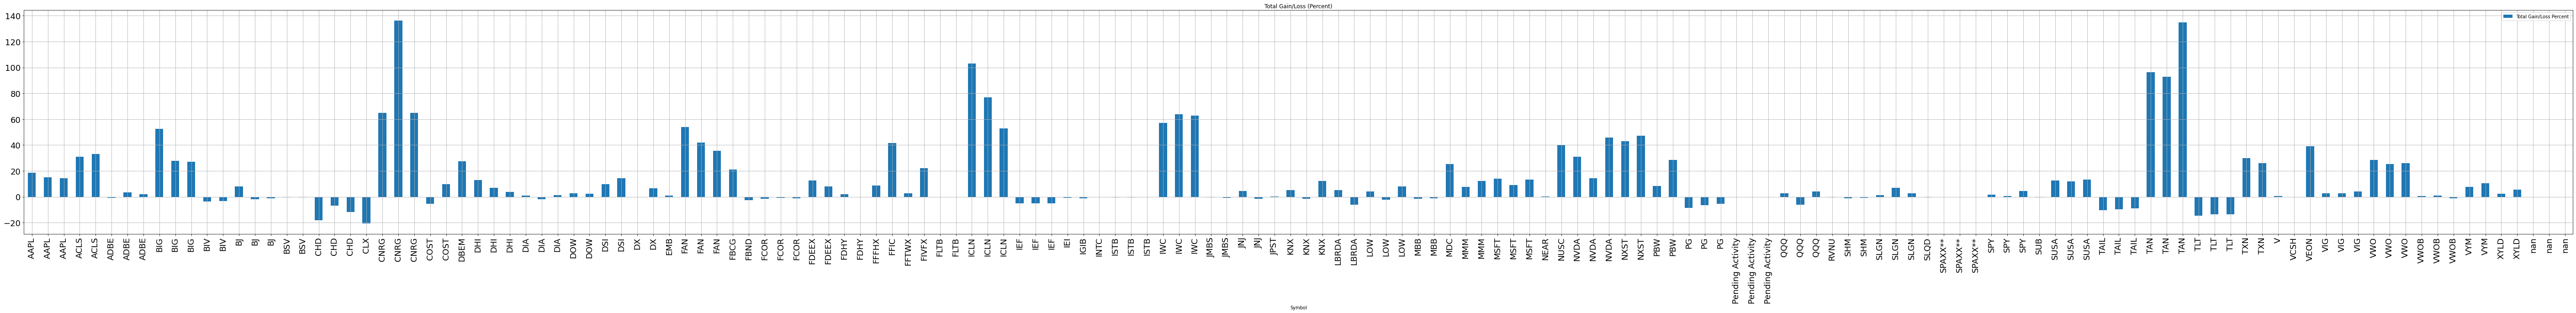

In [5]:
# bar plot for total gain/loss
stock_df_cleaned.plot.bar(x="Symbol", y="Total Gain/Loss Percent", figsize=(100,9), grid=True, title='Total Gain/Loss (Percent)', fontsize=18)

<AxesSubplot:title={'center':'Total Gain/Loss (Percent)'}, xlabel='Symbol'>

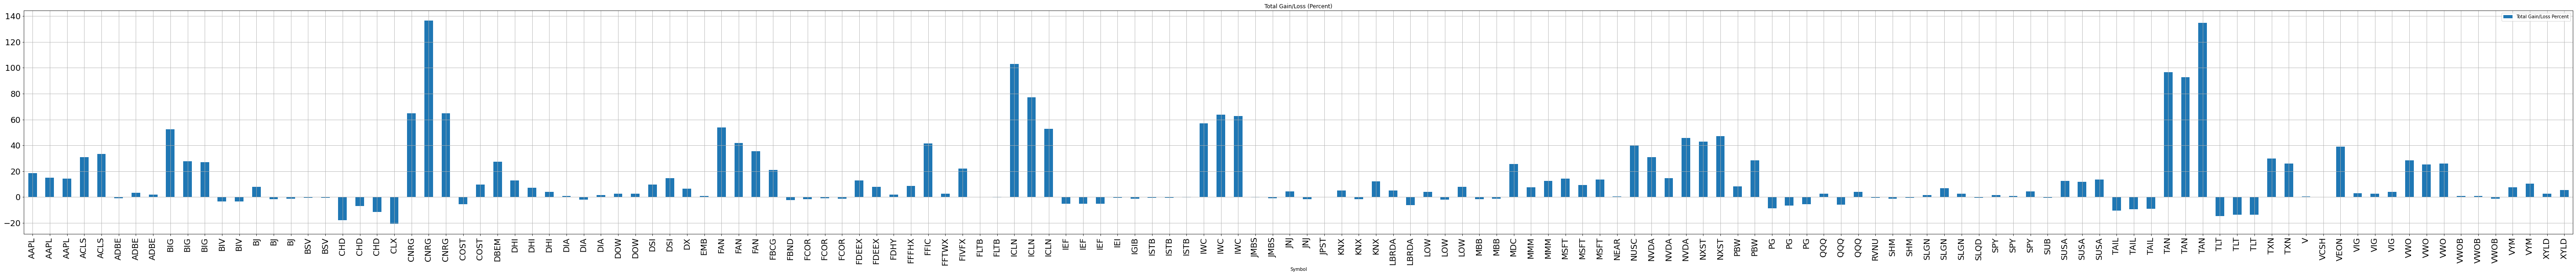

In [6]:
# Total Gain/Loss, omitting blank bars from chart by making a new df
tgl_df_01 = stock_df_cleaned.copy()
tgl_df_01 = tgl_df_01[tgl_df_01['Total Gain/Loss Percent'].notna()]
tgl_df_01.plot.bar(x="Symbol", y="Total Gain/Loss Percent", figsize=(100,9), grid=True, title='Total Gain/Loss (Percent)', fontsize=18)

<AxesSubplot:title={'center':'Total Gain/Loss vs. 52-Week Performance'}, xlabel='Symbol'>

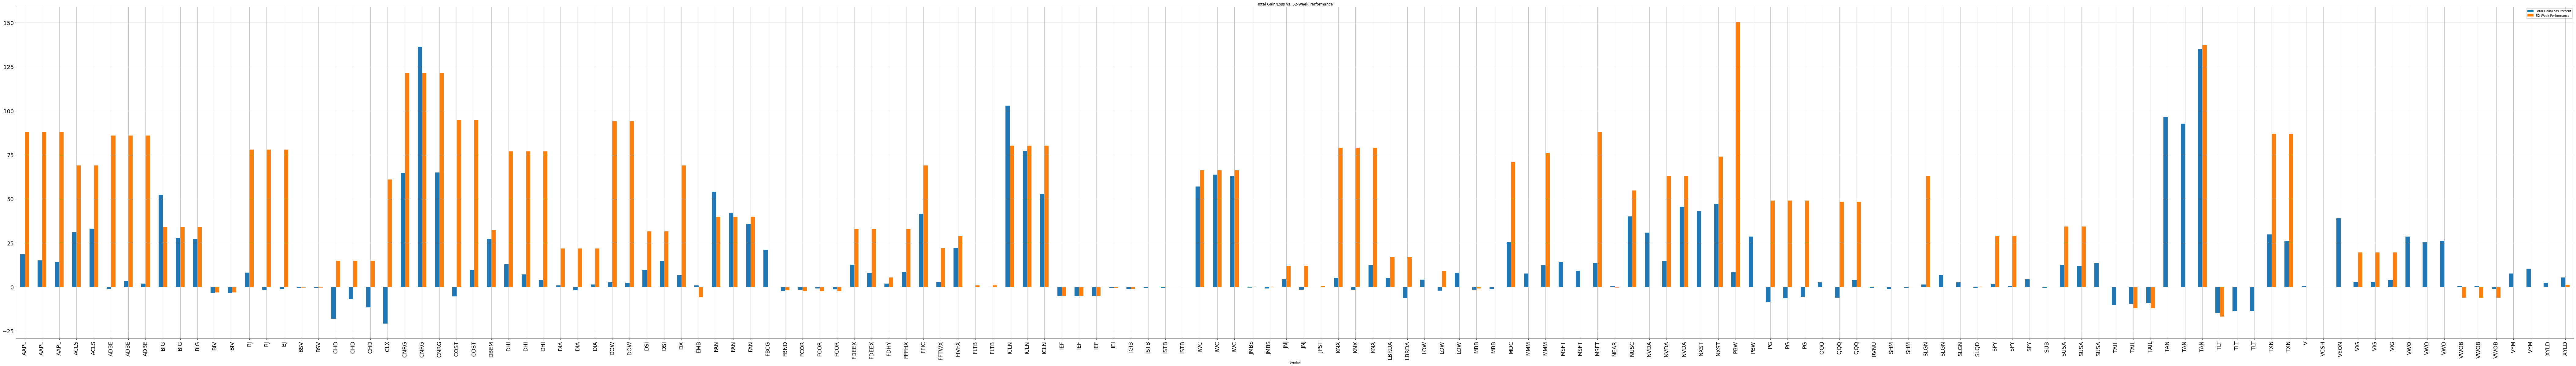

In [7]:
# Bar plot, gain/loss vs. 52-week performance
# a bit messy, but it works
tgl_df_01.plot.bar(x='Symbol', y=["Total Gain/Loss Percent", "52-Week Performance"], figsize=(150,20), grid=True, title="Total Gain/Loss vs. 52-Week Performance", fontsize=18)

<AxesSubplot:title={'center':'Recognia Technical Analysis'}, xlabel='Symbol'>

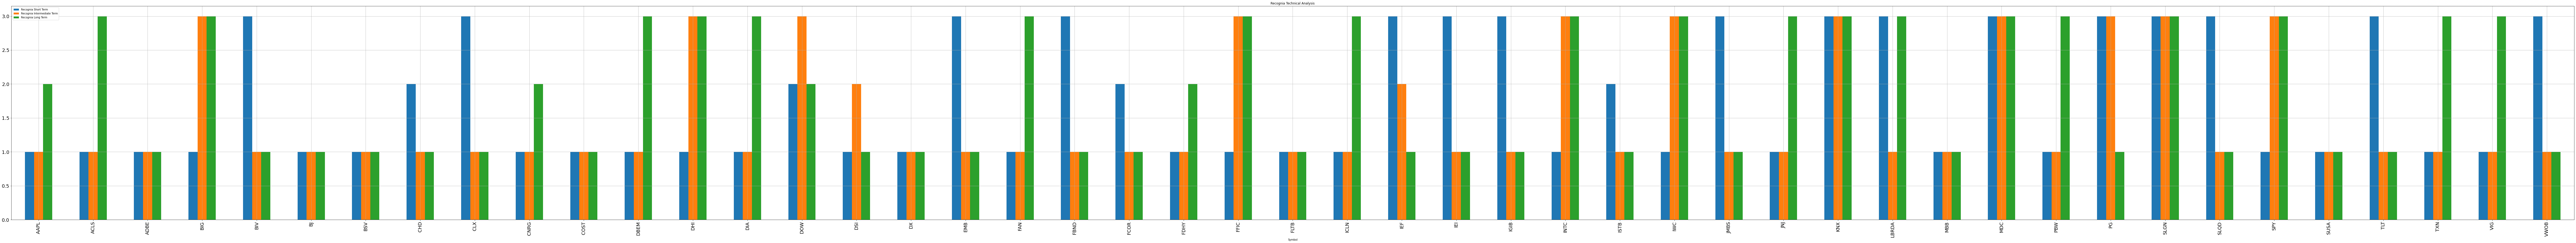

In [8]:
# recognia
# mapping a new df where recognia is based on numbers, 1 for weak, 2 for neutral, 3 for strong
def convert_recognia(value, **kwargs):
    if isinstance(value, str):
        if value == 'weak':
            value = np.int(1)
        elif value == 'neutral':
            value = np.int(2)
        elif value == 'strong':
            value = np.int(3)
        else:
            value = np.int(0)
    return np.float(value)
# dataframe_recogniaFloatforPlot
df_rfp = stock_df_cleaned.copy()
df_rfp = df_rfp.drop_duplicates(subset=['Symbol'])
for i in range(16, 19):
    df_rfp.iloc[:, i] = df_rfp.apply(lambda x: convert_recognia(x[i]), axis=1)

df_rfp = df_rfp[df_rfp['Recognia Short Term'].notna()]

df_rfp.plot.bar(x="Symbol", y=["Recognia Short Term", "Recognia Intermediate Term", "Recognia Long Term"], figsize=(175, 15), grid=True, title="Recognia Technical Analysis", fontsize=18)

<AxesSubplot:title={'center':'Key Stats'}, xlabel='Symbol'>

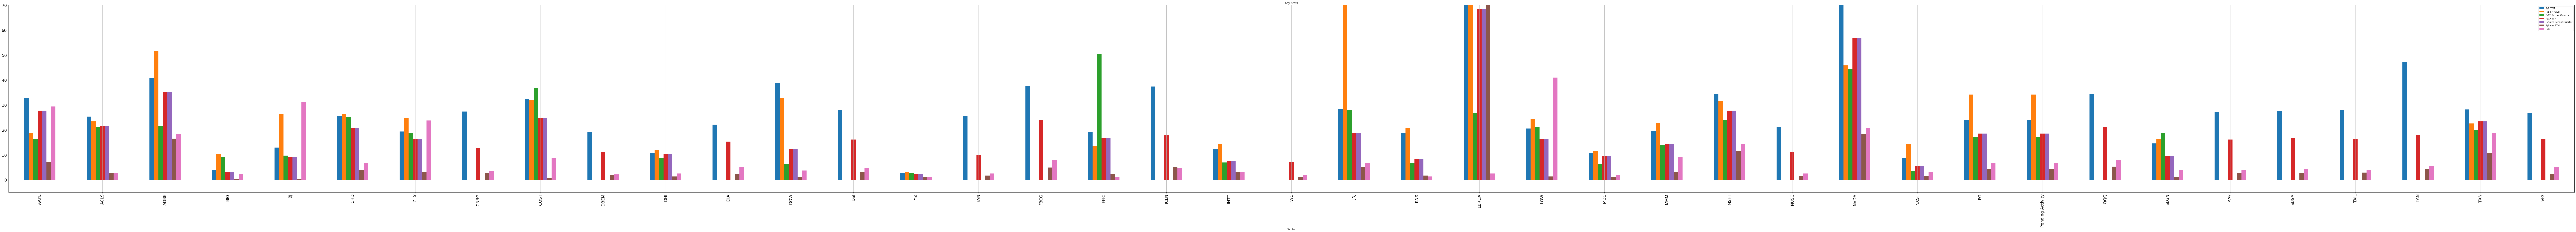

In [9]:
# Key stats
ks_df = stock_df_cleaned.copy()

ks_df = ks_df[ks_df['P/B'].notna()] # w/ the portfolio I have tested this code w/, every security w/ any key stats at least had a P/B ratio.
ks_df = ks_df.drop_duplicates(subset=['Symbol'])

ks_df.plot.bar(x="Symbol", y=['P/E TTM', 'P/E 5-Yr Avg', 'P/CF Recent Quarter', 'P/CF TTM', 'P/Sales Recent Quarter', 'P/Sales TTM', 'P/B'], figsize=(200, 15), grid=True, title="Key Stats", ylim=(-5, 70), fontsize=18)

<AxesSubplot:title={'center':'Fundamental Analysis'}, xlabel='Symbol'>

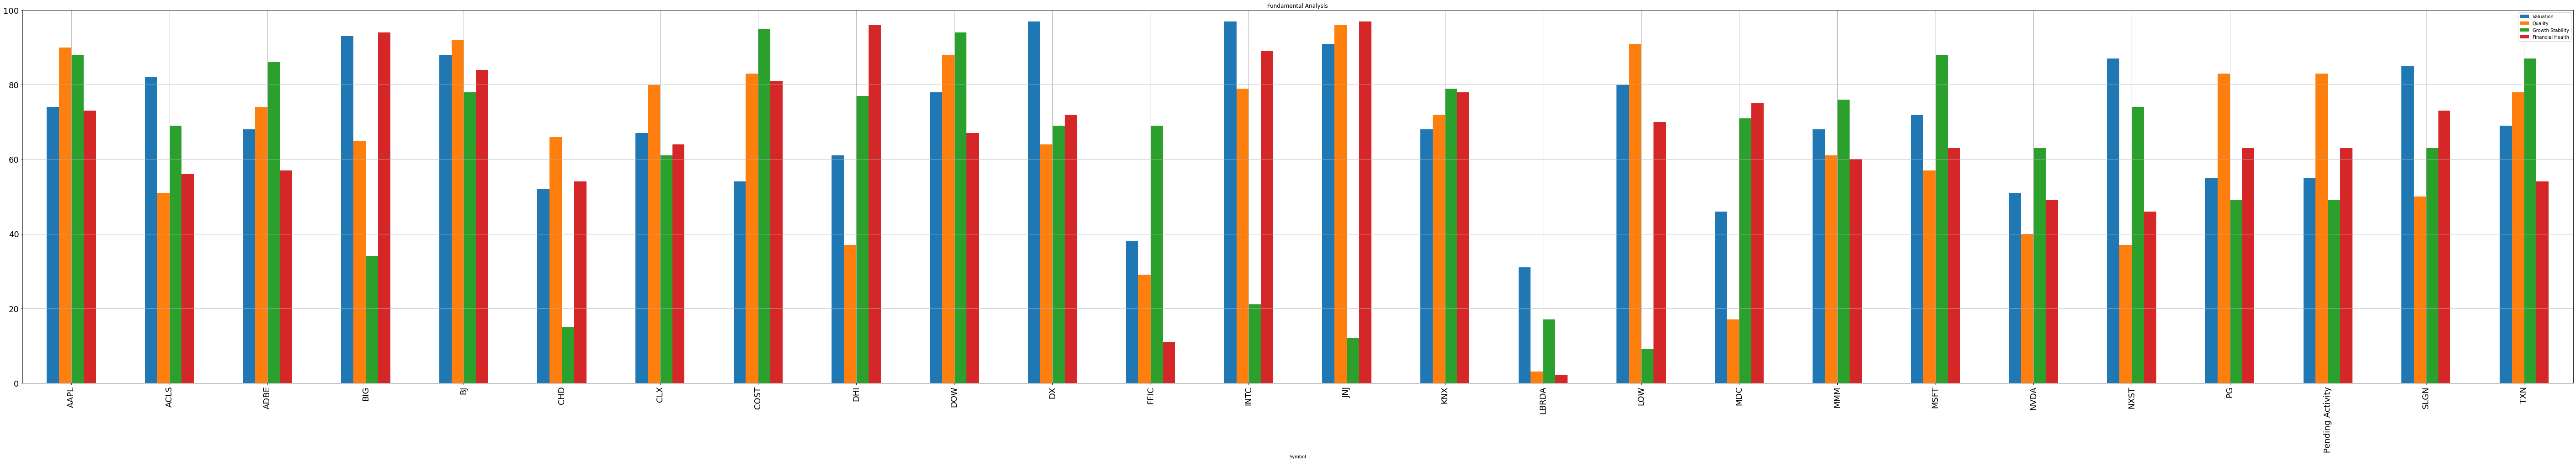

In [10]:
# Fundamental Analysis
fa_df = stock_df_cleaned.copy()
fa_df = fa_df[fa_df['Valuation'].notna()]
fa_df = fa_df.drop_duplicates(subset=["Symbol"])

fa_df.plot.bar(x="Symbol", y=['Valuation', 'Quality', 'Growth Stability', 'Financial Health'], figsize=(100, 15), grid=True, title='Fundamental Analysis', ylim=(0, 100), fontsize=18)

<AxesSubplot:title={'center':'Equity Summary Score'}, xlabel='Symbol'>

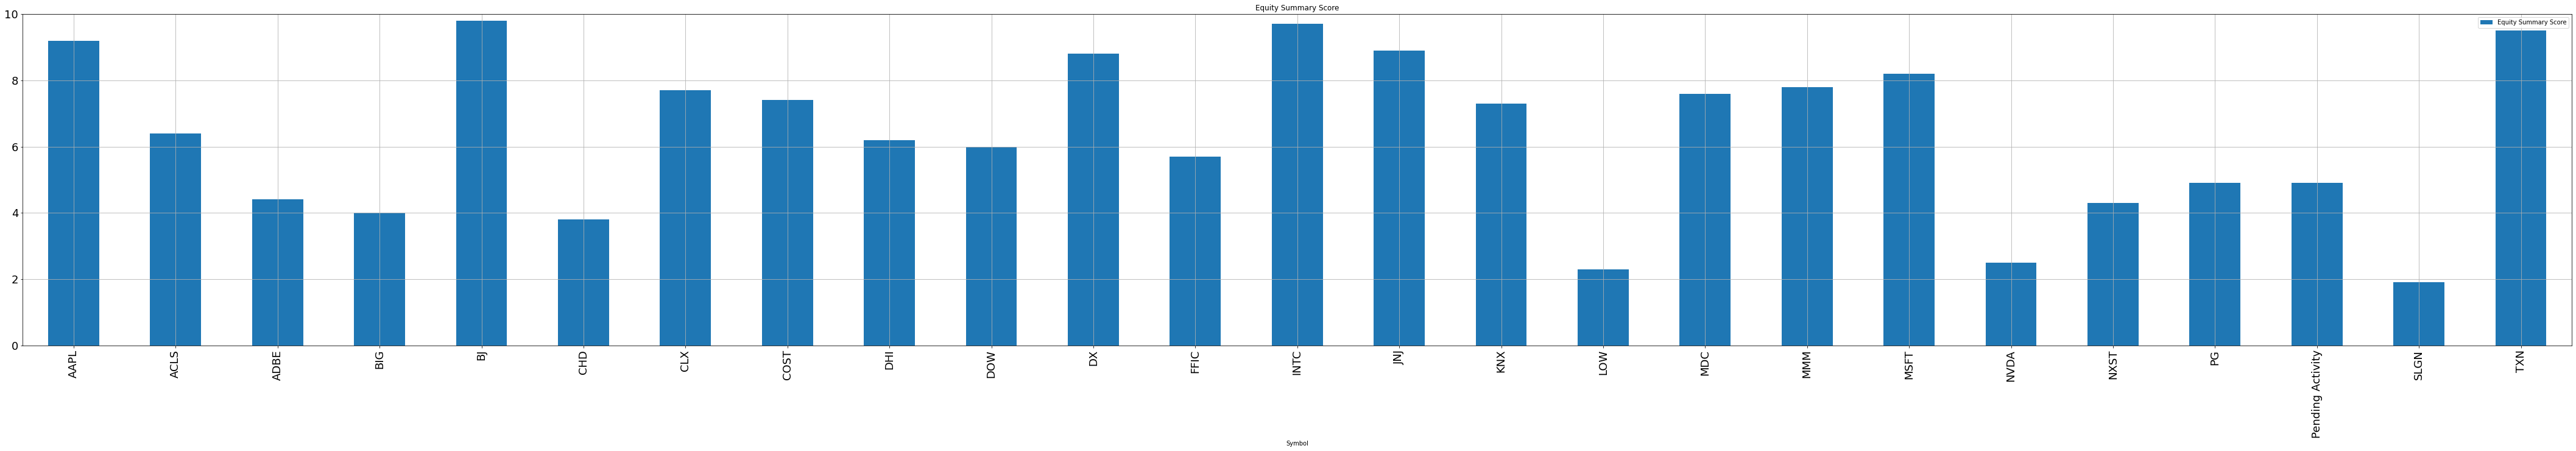

In [11]:
# Equity Summary Score
ess_df = stock_df_cleaned.copy()
ess_df = ess_df[ess_df["Equity Summary Score"].notna()]
ess_df = ess_df.drop_duplicates(subset=["Symbol"])

ess_df.plot.bar(x='Symbol', y='Equity Summary Score', figsize=(75, 10), grid=True, title='Equity Summary Score', ylim=(0, 10), fontsize=18)

In [107]:
# Compare a security's performance to that of the S&P 500
import yfinance as yf
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource

def pct_change(df):
    df['Close'] = (df.iloc[0].Close / df.Close)
    return df

def close_change(df):
    i = 0
    for row in df.itertuples():
        if i == 0:
            i += 1
            continue
        else:
            df.iloc[i, 3] = 100 * ( 1 - (df.iloc[0, 3] / df.iloc[i, 3]))
            i += 1
    df.iloc[0, 3] = np.nan
    return df


# change the symbol variable to the security you'd like to look up
symbol = 'NXST'

# change the time frame you'd like to compare the two over
# valid times are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
# intervals are 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo (intraday does not extend past 60 days)
period = '2y'
interval = '1d'

stock = yf.Ticker(symbol)
spy = yf.Ticker('SPY')  # just uses the SPY ETF

stock = stock.history(period=period, interval=interval)
spy = spy.history(period=period, interval=interval)


# data = yf.download("AAPL SPY", period=period, interval=interval)

# get data ready
#stock = stock.groupby('Date')['Close'].apply(pct_change)
#spy = spy.groupby('Date')['Close'].apply(pct_change)

stock = close_change(stock)
spy = close_change(spy)

# create ColumnDataSource objects for each security
stock_cds = ColumnDataSource(stock)
spy_cds = ColumnDataSource(spy)

output_notebook()


fig = figure(x_axis_type='datetime',
plot_height=300, plot_width=600,
title=f'{symbol} vs. SPY',
x_axis_label='DateTime', y_axis_label='Price Percent Change')

fig.line('Date', 'Close', source=stock_cds, line_color='red', legend_label=f'{symbol}')
fig.line('Date', 'Close', source=spy_cds, line_color='blue', legend_label='SPY')
fig.legend.location = 'top_left'
fig.legend.click_policy = 'hide'

# fig.multiline()

show(fig)


Loading BokehJS ...

In [165]:
stock["Low"]

Date
2019-03-13     44.302216
2019-03-14     44.703803
2019-03-15     44.992758
2019-03-18     45.494750
2019-03-19     45.526581
                 ...    
2021-03-08    116.209999
2021-03-09    118.790001
2021-03-10    119.449997
2021-03-11    121.260002
2021-03-12    119.160004
Name: Low, Length: 505, dtype: float64

In [38]:
stock.iloc[0].Close / stock.iloc[2].Close

0.9763056381423941

In [46]:
type(stock.iloc[0])

numpy.float64

In [91]:
100 * (1 - (stock.iloc[0, 3] / stock.iloc[1, 3]))

-14.764056168807095

In [80]:
stock.iloc[0, 3]

68.95796966552734

In [81]:
stock.iloc[1, 3]

60.08673095703125

In [83]:
stock.iloc[250, 3]

121.95999908447266